In [5]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

import yfinance as yf

In [6]:
#
# Funciones auxiliares
#
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

In [18]:
#
# Lectura de los datos
#
from pandas_datareader import data

import yfinance as yf
yf.pdr_override() 

symbol = 'SPY'
data_source='google'
start_date = '2021-06-28'
end_date = '2023-06-28'
dataset = data.get_data_yahoo(symbol, start_date, end_date)

#dataset = pd.read_csv('AAPL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])


dataset.head()
dataset

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-06-28,427.170013,427.649994,425.890015,427.470001,414.705414,53159600
2021-06-29,427.880005,428.559998,427.130005,427.700012,414.928589,35970500
2021-06-30,427.209991,428.779999,427.179993,428.059998,415.277771,64827900
2021-07-01,428.869995,430.600006,428.799988,430.429993,417.577026,53441000
2021-07-02,431.670013,434.100006,430.519989,433.720001,420.768799,57697700
...,...,...,...,...,...,...
2023-06-21,436.160004,436.989990,434.329987,434.940002,434.940002,76982300
2023-06-22,433.950012,436.619995,433.600006,436.510010,436.510010,70637200
2023-06-23,432.929993,435.059998,432.470001,433.209991,433.209991,92028700


503
82


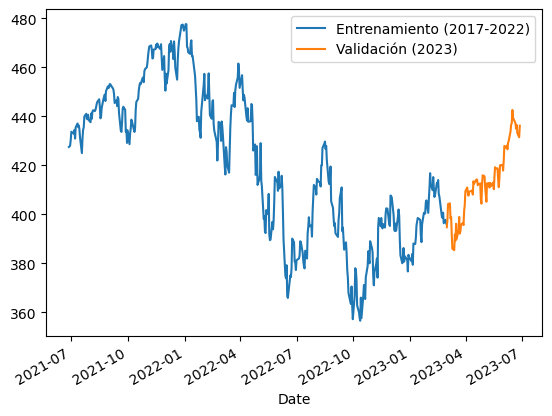

In [19]:
#
# Sets de entrenamiento y validación 
# La LSTM se entrenará con datos de 2016 hacia atrás. La validación se hará con datos de 2017 en adelante.
# En ambos casos sólo se usará el valor más alto de la acción para cada día
#
set_entrenamiento = dataset[:'2023-02'].iloc[:,3:4]
set_validacion = dataset['2023-03':].iloc[:,3:4]

print(len(set_entrenamiento)+len(set_validacion))
print(len(set_validacion))
set_entrenamiento['Close'].plot(legend=True)
set_validacion['Close'].plot(legend=True)
plt.legend(['Entrenamiento (2017-2022)', 'Validación (2023)'])
plt.show()


In [20]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

In [21]:
# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 60 #150
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)
#print(set_entrenamiento_escalado)
#print(type(set_entrenamiento_escalado))
for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])
    #print(set_entrenamiento_escalado[i-time_step:i,0])
    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
print(X_train)

[[0.58530753 0.58720609 0.5901775  ... 0.7002889  0.63953789 0.63615362]
 [0.58720609 0.5901775  0.60973998 ... 0.63953789 0.63615362 0.67106886]
 [0.5901775  0.60973998 0.63689647 ... 0.63615362 0.67106886 0.71498142]
 ...
 [0.32480403 0.31919121 0.42195623 ... 0.35105242 0.3465127  0.36401162]
 [0.31919121 0.42195623 0.41948007 ... 0.3465127  0.36401162 0.32868353]
 [0.42195623 0.41948007 0.41560057 ... 0.36401162 0.32868353 0.33982679]]


In [22]:
# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#X_train

In [23]:
#
# Red LSTM
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50
modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.fit(X_train,Y_train,epochs=20,batch_size=32)

Epoch 1/20
12/12 [==============================] - 4s 54ms/step - loss: 0.0710
Epoch 2/20
12/12 [==============================] - 0s 30ms/step - loss: 0.0127
Epoch 3/20
12/12 [==============================] - 0s 28ms/step - loss: 0.0122
Epoch 4/20
12/12 [==============================] - 1s 52ms/step - loss: 0.0097
Epoch 5/20
12/12 [==============================] - 1s 57ms/step - loss: 0.0112
Epoch 6/20
12/12 [==============================] - 0s 37ms/step - loss: 0.0085
Epoch 7/20
12/12 [==============================] - 0s 32ms/step - loss: 0.0084
Epoch 8/20
12/12 [==============================] - 1s 51ms/step - loss: 0.0081
Epoch 9/20
12/12 [==============================] - 0s 37ms/step - loss: 0.0068
Epoch 10/20
12/12 [==============================] - 0s 39ms/step - loss: 0.0076
Epoch 11/20
12/12 [==============================] - 0s 34ms/step - loss: 0.0061
Epoch 12/20
12/12 [==============================] - 0s 30ms/step - loss: 0.0064
Epoch 13/20
12/12 [==================

In [24]:
# Validación (predicción del valor de las acciones)
x_test = set_validacion.values
x_test = sc.transform(x_test)
print(len(x_test))
X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
print(len(X_test))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)
print(len(prediccion))
#prediccion = [prediccion[i][0] for i in range( len(prediccion)) ]
#print( type(prediccion) )

82
22


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 769ms/step
22




set_entrenamiento['Close'].plot(legend=True)

set_validacion_g = pd.DataFrame()
set_validacion_g['validacion'] = dataset['2023':].iloc[:,3:4]
set_validacion_g.index = dataset['2023':].index


set_validacion_p_g = pd.DataFrame()
set_validacion_p_g['prediccion'] = [ prediccion[i][0] for i in range(len(prediccion)) ]
set_validacion_p_g.index = dataset['2023':].index

set_validacion_p_g['prediccion'].plot(legend=True)
set_validacion_g['validacion'].plot(legend=True)
print(set_validacion_g)
#graficar_predicciones(set_validacion.values,prediccion)

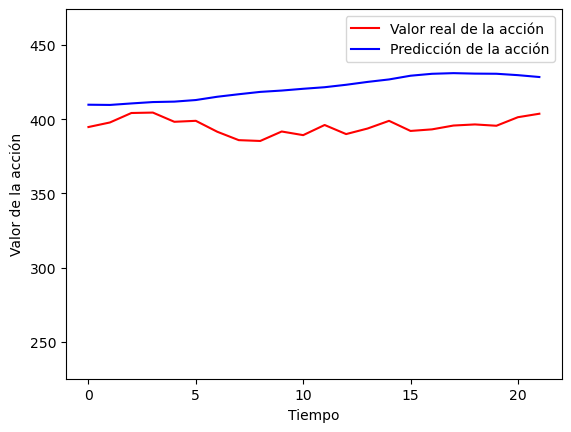

1/1 [==============================] - 0s 40ms/step


In [25]:
graficar_predicciones(set_validacion.values,prediccion)
prediccion = modelo.predict(X_test)

In [26]:
# Validación (predicción del valor de las acciones)
x_test = set_validacion.values
x_test = sc.transform(x_test)
print(len(x_test))
X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
print(len(X_test))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print(X_test)
prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)
print(len(prediccion))
#prediccion = [prediccion[i][0] for i in range( len(prediccion)) ]
#print( type(prediccion) )

82
22
[[[0.31514647]
  [0.34048702]
  [0.39314905]
  ...
  [0.51366087]
  [0.47486588]
  [0.45010319]]

 [[0.34048702]
  [0.39314905]
  [0.39546022]
  ...
  [0.47486588]
  [0.45010319]
  [0.47948823]]

 [[0.39314905]
  [0.39546022]
  [0.34428389]
  ...
  [0.45010319]
  [0.47948823]
  [0.52381341]]

 ...

 [[0.32224524]
  [0.36970706]
  [0.38910456]
  ...
  [0.66545604]
  [0.64696664]
  [0.65992585]]

 [[0.36970706]
  [0.38910456]
  [0.43607115]
  ...
  [0.64696664]
  [0.65992585]
  [0.63268673]]

 [[0.38910456]
  [0.43607115]
  [0.44894773]
  ...
  [0.65992585]
  [0.63268673]
  [0.61807684]]]
1/1 [==============================] - 0s 39ms/step
22


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [27]:
#
# Funciones auxiliares
#
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()